In [1]:
folder = '../logs/commons_harvest_open/scenario_0_5players'
arch = 'generative_agents'
llm_model = 'gpt4o_mini'

In [2]:
import os

simulations_folder = os.path.join(folder, arch, llm_model)
sim_folder = os.listdir(simulations_folder)[0]
sim_folder_path = os.path.join(simulations_folder, sim_folder)
sim_log_file = os.path.join(sim_folder_path, '2024-10-03--10-04-17.log')

FileNotFoundError: [Errno 2] No such file or directory: '../logs/commons_harvest_open/scenario_0_5players/generative_agents/gpt4o_mini'

In [47]:
turn_start_pat = r'^################Agent\'s (\w+) turn################'
prompt_start_pat = r'^step \d+ - step_\d+ - INFO - llm.base_llm - completion:182 - Prompt:'
prompt_end_pat = r'^None - step_0 - INFO - httpx - _send_single_request:1013 - HTTP Request: POST https://api\.openai\.com/v1/chat/completions'
invalid_act_prompt_pat =r'^step \d+ - step_\d+ - WARNING - agent.cognitive_modules.act - actions_sequence:7[05] - Could not find action in the response_dict'
act_prompt_unique_feat_pat = r'^\s+"Consequences":\s+string+\s+[\\]+\s+.+'
response_start_pat = r'^step \d+ - step_\d+ - INFO - llm.base_llm - completion:185 - Response:'
response_end_pat = r'^step \d+ - step_\d+ - INFO - llm.base_llm - completion:188 - Prompt tokens: \d+'
game_observations_pat = r'^step \d+ - step_\d+ - INFO - __main__ - game_loop:6[01] - \w+ Observations: '

In [48]:
import re
import numbers

def extract_prompts(sim_log_file, type = None):
    cot_agent_prompt = type == 'cot_agent'
    # init flags
    prompt_flags = dict(
        is_prompt_start = False,
        is_act_prompt = False
    )
    response_flags = dict(
        is_response_start = False,
    )
    turn_flags = dict( # This flags are reset when the turn change
        act_response_successful = False
    )
    prompt_response_pair_flags = dict( # This flags can be set between the prompt start and response end, are reinitialized after the response end
        act_prompt_called = False
    )
    stats = dict(
        total_prompts = 0,
        total_turns = 0,
        invalid_prompts = 0,
        act_prompts = 0,
    )
    tmp_prompt_data = dict(
        prompt_content = '',
    )
    tmp_response_data = dict(
        response_content = '',
    )
    tmp_turn_data = dict( # This info is only available while the turn has not changed
        game_observations = ''
    )
    accum_data = dict(
        act_prompts_content = [],
        act_prompts_response = [],
        game_observations_for_act = []
    )
    agent = None

    act_prompt_unique_feat_pat = r'^\s+"Consequences":\s+string+\s+[\\]+\s+.+'
    if type == 'GA':
        act_prompt_unique_feat_pat = r'^\s+"Final analysis:\s+string+\s+[\\]+\s+.+'

    def reset_flags(flags_dicts):
        for flag in flags_dicts:
            if isinstance(flags_dicts[flag], bool):
                flags_dicts[flag] = False
            elif isinstance(flags_dicts[flag], numbers.Number):
                flags_dicts[flag] = 0
            elif isinstance(flags_dicts[flag], str):
                flags_dicts[flag] = ''
            else:
                raise Exception(f'Unsupported type of flag: {type(flags_dicts[flag])}')
            
    def end_turn_hook():
        stats['total_turns'] += 1
        if tmp_turn_data['game_observations'] and turn_flags['act_response_successful']:
            accum_data['game_observations_for_act'].append(tmp_turn_data['game_observations'])

    def end_prompt_hook(prompt_flags, stats, accum_data, tmp_prompt_data, turn_flags):
        stats['total_prompts'] += 1

        # Is it was an act prompt save it
        if prompt_flags['is_act_prompt']:
            stats['act_prompts'] += 1
            accum_data['act_prompts_content'].append(tmp_prompt_data['prompt_content'])
            prompt_response_pair_flags['act_prompt_called'] = True

        reset_flags(tmp_prompt_data)
        reset_flags(prompt_flags)


    with open(sim_log_file) as file:
        for line in file:
            ###### Turns

            # Check if it is a new turn
            is_new_turn = re.match(turn_start_pat, line)
            if is_new_turn:
                agent = is_new_turn.group(1)

                end_turn_hook()

                # Reset flags
                reset_flags(turn_flags)
                reset_flags(tmp_turn_data)
                if prompt_flags['is_prompt_start']:
                    print('There was a prompt ending that was not catch')
                    reset_flags(tmp_prompt_data)
                    reset_flags(prompt_flags)
                if response_flags['is_response_start']:
                    print('There was a response ending that was not catch')
                    reset_flags(tmp_response_data)
                    reset_flags(response_flags)

            ###### Prompts
            
            # Check if a prompt starts
            prompt_start_match = re.match(prompt_start_pat, line)
            if prompt_start_match:
                prompt_flags['is_prompt_start'] = True

            # Check if a prompt ends
            prompt_end_match = re.match(prompt_end_pat, line)
            if prompt_flags['is_prompt_start'] and prompt_end_match:
                end_prompt_hook(prompt_flags, stats, accum_data, tmp_prompt_data, turn_flags)

            # Check if the prompt was invalid
            if (not prompt_flags['is_prompt_start']) and re.match(invalid_act_prompt_pat, line):
                stats['invalid_prompts'] += 1
                stats['act_prompts'] -= 1
                # Delete the last act prompt
                accum_data['act_prompts_content'] = accum_data['act_prompts_content'][:-1]
                prompt_response_pair_flags['act_prompt_called'] = False
                accum_data['act_prompts_response'] = accum_data['act_prompts_response'][:-1]
                turn_flags['act_response_successful'] = False

            # Check if it is an act prompt
            act_prompt_match = prompt_flags['is_prompt_start'] and re.match(act_prompt_unique_feat_pat, line)
            if cot_agent_prompt: # The only prompt is the act prompt
                act_prompt_match = prompt_flags['is_prompt_start']
            if act_prompt_match:
                prompt_flags['is_act_prompt'] = True

            # Save the prompt_content
            if prompt_flags['is_prompt_start']:
                tmp_prompt_data['prompt_content'] += line

            ###### Prompt Responses

            # Check if a prompt response starts
            if (not prompt_flags['is_prompt_start']) and re.match(response_start_pat, line):
                response_flags['is_response_start'] = True
                if prompt_flags['is_prompt_start']:
                    prompt_flags['is_prompt_start'] = False

            # Save the response content
            if response_flags['is_response_start']:
                tmp_response_data['response_content'] += line

            # Check if the response ends
            if response_flags['is_response_start'] and re.match(response_end_pat, line):
                response_flags['is_response_start'] = False
                if prompt_response_pair_flags['act_prompt_called']:
                    accum_data['act_prompts_response'].append(tmp_response_data['response_content'])
                    turn_flags['act_response_successful'] = True
                reset_flags(tmp_response_data)
                reset_flags(response_flags)
                reset_flags(prompt_response_pair_flags)

            ###### Game observations
            if (not prompt_flags['is_prompt_start']) and (not response_flags['is_response_start']) and re.match(game_observations_pat, line):
                tmp_turn_data['game_observations'] = line


    print('total prompts:', stats['total_prompts'], 'invalid_prompts:', stats['invalid_prompts'], 'act_prompts', stats['act_prompts'], len(accum_data['act_prompts_content']), \
        'act_responses:', len(accum_data['act_prompts_response']))
    return accum_data

In [49]:
accum_data = extract_prompts('../logs/commons_harvest_open/scenario_0_5players/GA_all/gpt4o_mini/2024-11-01--15-41-09/2024-11-01--15-41-09.log', type='GA')

total prompts: 569 invalid_prompts: 1 act_prompts 146 146 act_responses: 146


In [50]:
import ast
import os
import sys
import numpy as np
sys.path.append(os.path.abspath('../'))
from game_environment.utils import connected_elems_map, get_local_position_from_global
from utils.math import manhattan_distance


def get_scene_info(observations):
    scene_description_pat = r'.+\], Scene descriptions: (\{.+)'
    scene_info = re.match(scene_description_pat, observations).group(1)
    scene_info = ast.literal_eval(scene_info)
    return scene_info


def get_act_reponse(act_prompt_response, cot_agent_prompt = False):
    action_pat = r'\s*"[Aa]nswer":\s+"(.+?)"'
    action = re.search(action_pat, act_prompt_response, re.MULTILINE).group(1)
    return action


def get_relevant_info_from_observations(observations):
    agent_ids = ['0', '1', '2', '3', '4', '5', '6']
    matrix = np.array([list(row) for row in observations['observation'].split('\n') if row != ''])
    trees = connected_elems_map(matrix, ['A', 'G'] + agent_ids)
    trees_els = []
    trees_info = []
    for tree in trees:
        els = np.array(trees[tree]['elements'])
        tree_els = matrix[els[:,0], els[:,1]]
        apples_in_tree = (tree_els == 'A').sum()
        grass_in_tree = (tree_els == 'G').sum()
        tree_size = apples_in_tree + grass_in_tree
        # If the tree is only the agent
        if tree_size == 0:
            continue
        distance_to_tree = manhattan_distance(observations['local_position'], trees[tree]['center'])
        # print(f'Distance: {distance_to_tree}, apples:{apples_in_tree}, grass:{grass_in_tree}, size:{tree_size}')
        trees_els.append({'distance': distance_to_tree, 'apples': apples_in_tree, 'grass': grass_in_tree, 'size': tree_size})
        trees_info.append(trees[tree])
    return {'trees_stats': trees_els, 'map': matrix, 'trees': trees_info}

def score_action(trees_info, observations, action):
    agent_ids = ['0', '1', '2', '3', '4', '5', '6', '7']
    OBS_WINDOW_SIZE = (11, 11)
    action_name = None

    if re.match(r'explore', action, re.IGNORECASE):
        action_name = 'explore'
        observed_apples = sum(map(lambda x: x['apples'], trees_info['trees_stats']))
        if observed_apples <= 3:
            return action_name, 1
        elif observed_apples <= 6:
            return action_name, 0.5
        else:
            return action_name, 0
    elif re.match(r'go to', action, re.IGNORECASE):
        action_name = 'go_to'
        destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
        if destination:
            destination = tuple(map(int, destination.group(1).split(',')))
            destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                # If only one tree
                if len(trees_info['trees_stats']) == 1:
                    apples_in_tree = trees_info['trees_stats'][0]['apples']
                    if apples_in_tree <= 3:
                        return action_name, 1
                    else:
                        return action_name, 0
                else:
                    apples_in_total = sum(map(lambda x: x['apples'], trees_info['trees_stats']))
                    if apples_in_total < 5:
                        return action_name, 0.5
                    else:
                        return action_name, 0
            # If the destination is an apple
            elif trees_info['map'][destination[0], destination[1]] == 'A':
                trees_mask = list(map(lambda x: any(map(lambda el: el == list(destination), x['elements'])), trees_info['trees']))
                tree_id = trees_mask.index(True)

                tree = trees_info['trees_stats'][tree_id]
                apples = tree['apples']
                if apples >= 4:
                    return action_name, 1
                elif apples == 1:
                    return action_name, 0
                else:
                    trees_with_apples = list(filter(lambda x: x['apples']>0, trees_info['trees_stats']))
                    tree_with_most_apples = max(trees_info['trees_stats'], key=lambda x : x['apples'])
                    tree_with_most_apples_id = trees_info['trees_stats'].index(tree_with_most_apples)
                    if len(trees_with_apples) == 1 or tree_with_most_apples_id == tree_id:
                        return action_name, 0.5
                    else:
                        return action_name, 0
            # If the destination is grass or empty
            elif trees_info['map'][destination[0], destination[1]] == 'G' or trees_info['map'][destination[0], destination[1]] == 'F':
                # If only one tree
                if len(trees_info['trees_stats']) == 1:
                    apples_in_tree = trees_info['trees_stats'][0]['apples']
                    if apples_in_tree <= 3:
                        return action_name, 1
                    else:
                        return action_name, 0
                else:
                    apples_in_total = sum(map(lambda x: x['apples'], trees_info['trees_stats']))
                    if apples_in_total < 5:
                        return action_name, 0.5
                    else:
                        return action_name, 0
            # If destination is another agent or outbounds
            else:
                return action_name, 0

        else:
            return action_name, 0
    elif re.match(r'immobilize', action, re.IGNORECASE):
        action_name = 'immobilize'
        target = re.match(r'immobilize\s+.+at\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\)\]]', action, re.IGNORECASE)
        if not target:
            return action_name, 0
        else:
            target = tuple(map(int, target.group(1).split(',')))
            target = get_local_position_from_global(observations['orientation'], target, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if target[0] < 0 or target[0] >= OBS_WINDOW_SIZE[0] or target[1] < 0 or target[1] >= OBS_WINDOW_SIZE[1]:
                print('Attacking a player out of the obs window.', 'Target:', target, 'Observations', observations, action)
                return action_name, 0
            elif trees_info['map'][target[0], target[1]] in agent_ids:
                # If there is no tree
                if len(trees_info['trees']) == 0:
                    return action_name, 0
                tree_distance_to_target_agent = list(map(lambda x: manhattan_distance(x['center'], target), trees_info['trees']))
                # print('tree_distance_to_agent', tree_distance_to_target_agent)
                closest_tree_to_target = tree_distance_to_target_agent.index(min(tree_distance_to_target_agent))
                # print('closes_tree_to_agent', closes_tree_to_target)
                if trees_info['trees_stats'][closest_tree_to_target]['apples'] <= 3:
                    return action_name, 1
                else:
                    # If there is a single tree
                    if len(trees_info['trees_stats']) == 1:
                        return action_name, 0.5
                    else:
                        return action_name, 0
            else:
                return action_name, 0
    elif re.match(r'stay\s+put', action, re.IGNORECASE):
        action_name = 'stay_put'
        # If there is no tree
        if len(trees_info['trees']) == 0:
            return action_name, 0
        trees_with_apples = list(filter(lambda x: x['apples']>0, trees_info['trees_stats']))
        # If single tree apple
        if len(trees_with_apples) == 1:
            apples_in_tree = trees_with_apples[0]['apples']
            if apples_in_tree <= 3:
                return action_name, 1
            else:
                return action_name, 0
        else:
            apples_in_total = sum(map(lambda x: x['apples'], trees_info['trees_stats']))
            if apples_in_total < 5:
                return action_name, 0.5
            else:
                return action_name, 0
    else:
        action_name = 'unknow'
        print(f'ERROR: action was not catch "{action}"')
        return action_name, 0

def eval_action(raw_observations, act_prompt_response, type= None, score_action_fn = None):
    cot_agent_prompt = type == 'cot_agent'
    # print('raw_observations', raw_observations)
    observations = get_scene_info(raw_observations)
    scene_info = get_relevant_info_from_observations(observations)
    # print(scene_info)
    action = get_act_reponse(act_prompt_response, cot_agent_prompt=cot_agent_prompt)
    # print(action)
    return score_action_fn(scene_info, observations, action)

In [54]:
def get_file_score(file_data, type=None, score_action_fn = score_action):
    file_scores = {}
    for i in range(len(file_data['game_observations_for_act'])):
        action_name, score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=score_action_fn)
        file_scores[action_name] = file_scores.get(action_name, []) + [score]
        file_scores['total'] = file_scores.get('total', []) + [score]

    for key in file_scores.keys():
        file_scores[key] = sum(file_scores[key])/len(file_scores[key]), len(file_scores[key])
    return file_scores

get_file_score(accum_data)

{'go_to': (0.4311594202898551, 138),
 'total': (0.4517241379310345, 145),
 'stay_put': (0.8333333333333334, 6),
 'explore': (1.0, 1)}

## Get scores for all the files of an arch with a llm

In [55]:
def evaluate_the_complete_scenario(folder, file_score_fn = get_file_score):
    results = {}

    for arch in os.listdir(folder):
        results[arch] = {}
        for llm_model in os.listdir(os.path.join(folder, arch)):
            simulations_folder = os.path.join(folder, arch, llm_model)
            sim_scores = []
            for sim_folder in os.listdir(simulations_folder):
                log_filename = re.search(r'\d{4}-\d{2}-\d{2}--\d{2}-\d{2}-\d{2}', sim_folder).group(0) + '.log'
                log_path = os.path.join(simulations_folder, sim_folder, log_filename)
                if 'GA' in arch:
                    file_raw_info = extract_prompts(log_path, type='GA')
                else:
                    file_raw_info = extract_prompts(log_path, type=arch)
                try:
                    score = file_score_fn(file_raw_info, type=arch)
                except Exception as e:
                    print('log_path', log_path)
                    print('file_raw_info', file_raw_info)
                    raise Exception(e)
                sim_scores.append(score)
            results[arch][llm_model] = sim_scores

    return results

In [56]:
results = evaluate_the_complete_scenario(folder)
results

total prompts: 569 invalid_prompts: 1 act_prompts 146 146 act_responses: 146
total prompts: 748 invalid_prompts: 1 act_prompts 192 192 act_responses: 192
total prompts: 582 invalid_prompts: 0 act_prompts 144 144 act_responses: 144
total prompts: 830 invalid_prompts: 0 act_prompts 214 214 act_responses: 214
total prompts: 663 invalid_prompts: 0 act_prompts 172 172 act_responses: 172
total prompts: 578 invalid_prompts: 0 act_prompts 136 136 act_responses: 136
total prompts: 641 invalid_prompts: 1 act_prompts 158 158 act_responses: 158
total prompts: 1067 invalid_prompts: 1 act_prompts 256 256 act_responses: 256
total prompts: 910 invalid_prompts: 0 act_prompts 230 230 act_responses: 230
total prompts: 738 invalid_prompts: 1 act_prompts 175 175 act_responses: 175
total prompts: 532 invalid_prompts: 0 act_prompts 128 128 act_responses: 128
total prompts: 985 invalid_prompts: 0 act_prompts 240 240 act_responses: 240
total prompts: 757 invalid_prompts: 0 act_prompts 186 186 act_responses: 18

{'GA_all': {'gpt4o_mini': [{'go_to': (0.4311594202898551, 138),
    'total': (0.4517241379310345, 145),
    'stay_put': (0.8333333333333334, 6),
    'explore': (1.0, 1)},
   {'go_to': (0.42349726775956287, 183),
    'total': (0.41361256544502617, 191),
    'explore': (0.375, 4),
    'stay_put': (0.0, 4)},
   {'go_to': (0.42366412213740456, 131),
    'total': (0.45104895104895104, 143),
    'explore': (0.875, 8),
    'stay_put': (0.5, 4)},
   {'go_to': (0.42473118279569894, 186),
    'total': (0.4812206572769953, 213),
    'stay_put': (0.5714285714285714, 7),
    'explore': (0.975, 20)},
   {'go_to': (0.4444444444444444, 162),
    'total': (0.4649122807017544, 171),
    'stay_put': (0.7857142857142857, 7),
    'explore': (1.0, 2)},
   {'go_to': (0.5793650793650794, 126),
    'total': (0.6102941176470589, 136),
    'explore': (1.0, 9),
    'stay_put': (1.0, 1)},
   {'go_to': (0.5132450331125827, 151),
    'total': (0.5222929936305732, 157),
    'explore': (0.8, 5),
    'stay_put': (0.5, 

In [57]:
# results = evaluate_the_complete_scenario(folder)
keys = ['total', 'explore', 'go_to', 'stay_put', 'immobilize']
for key in keys:
    print(key)
    for arch in results:
        for llm_model in results[arch]:
            scores = list(filter(lambda x: key in x, results[arch][llm_model]))
            support = sum(map(lambda x: x[key][1], scores))
            scores = list(map(lambda x: x[key][0], scores))
            print(f'{arch} - {llm_model}: {np.mean(scores):.2f} - support: {support}')

total
GA_all - gpt4o_mini: 0.49 - support: 1815
GA_comm - gpt4o_mini: 0.54 - support: 1071
generative_agents - gpt4o_mini: 0.58 - support: 1183
cot_agent - gpt4o_mini: 0.61 - support: 918
explore
GA_all - gpt4o_mini: 0.79 - support: 73
GA_comm - gpt4o_mini: 0.95 - support: 58
generative_agents - gpt4o_mini: 0.90 - support: 119
cot_agent - gpt4o_mini: 0.88 - support: 367
go_to
GA_all - gpt4o_mini: 0.47 - support: 1683
GA_comm - gpt4o_mini: 0.52 - support: 987
generative_agents - gpt4o_mini: 0.55 - support: 1027
cot_agent - gpt4o_mini: 0.44 - support: 543
stay_put
GA_all - gpt4o_mini: 0.56 - support: 56
GA_comm - gpt4o_mini: 0.49 - support: 25
generative_agents - gpt4o_mini: 0.33 - support: 23
cot_agent - gpt4o_mini: 1.00 - support: 2
immobilize
GA_all - gpt4o_mini: 0.50 - support: 3
GA_comm - gpt4o_mini: 0.00 - support: 1
generative_agents - gpt4o_mini: 0.33 - support: 14
cot_agent - gpt4o_mini: 0.25 - support: 6


In [58]:
def get_file_score_by_step(file_data, type=None, score_action_fn = score_action):
    file_scores = {}
    for i in range(len(file_data['game_observations_for_act'])):
        step = re.search(r'step (\d+)', file_data['game_observations_for_act'][i]).group(1)
        action_name, score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=score_action_fn)
        file_scores[step] = file_scores.get(step, []) + [score]

    # Average the scores
    for key in file_scores.keys():
        file_scores[key] = sum(file_scores[key])/len(file_scores[key])
    return file_scores

results = evaluate_the_complete_scenario(folder, get_file_score_by_step)
results

total prompts: 569 invalid_prompts: 1 act_prompts 146 146 act_responses: 146
total prompts: 748 invalid_prompts: 1 act_prompts 192 192 act_responses: 192
total prompts: 582 invalid_prompts: 0 act_prompts 144 144 act_responses: 144
total prompts: 830 invalid_prompts: 0 act_prompts 214 214 act_responses: 214
total prompts: 663 invalid_prompts: 0 act_prompts 172 172 act_responses: 172
total prompts: 578 invalid_prompts: 0 act_prompts 136 136 act_responses: 136
total prompts: 641 invalid_prompts: 1 act_prompts 158 158 act_responses: 158
total prompts: 1067 invalid_prompts: 1 act_prompts 256 256 act_responses: 256
total prompts: 910 invalid_prompts: 0 act_prompts 230 230 act_responses: 230
total prompts: 738 invalid_prompts: 1 act_prompts 175 175 act_responses: 175
total prompts: 532 invalid_prompts: 0 act_prompts 128 128 act_responses: 128
total prompts: 985 invalid_prompts: 0 act_prompts 240 240 act_responses: 240
total prompts: 757 invalid_prompts: 0 act_prompts 186 186 act_responses: 18

{'GA_all': {'gpt4o_mini': [{'1': 0.8,
    '2': 1.0,
    '3': 0.5,
    '4': 1.0,
    '5': 1.0,
    '6': 1.0,
    '7': 1.0,
    '8': 0.5,
    '9': 0.75,
    '10': 0.0,
    '11': 0.25,
    '12': 0.5,
    '13': 0.3333333333333333,
    '14': 0.5,
    '15': 0.5,
    '16': 0.0,
    '17': 0.3333333333333333,
    '18': 0.5,
    '19': 0.25,
    '20': 0.25,
    '21': 0.5,
    '22': 0.625,
    '23': 0.0,
    '24': 0.25,
    '25': 0.3333333333333333,
    '26': 0.5,
    '27': 0.5,
    '28': 0.375,
    '29': 0.5,
    '30': 0.25,
    '31': 0.125,
    '32': 1.0,
    '33': 0.5,
    '34': 0.5,
    '36': 1.0,
    '38': 0.5,
    '39': 0.3,
    '40': 0.25,
    '41': 0.375,
    '42': 0.625,
    '43': 0.4,
    '44': 0.4,
    '45': 0.5,
    '46': 0.375,
    '47': 0.125,
    '48': 0.25,
    '49': 0.6666666666666666},
   {'1': 0.7,
    '2': 1.0,
    '3': 0.375,
    '4': 0.6666666666666666,
    '6': 1.0,
    '7': 0.5,
    '8': 0.75,
    '9': 0.8333333333333334,
    '10': 0.6666666666666666,
    '11': 0.6666666666

In [59]:
summary = {}
bin_size = 30
for arch in results:
    summary[arch] = {}
    for llm_model in results[arch]:
        summary[arch][llm_model] = {}
        scores = results[arch][llm_model]
        for i in range(0, 1000, bin_size):
            bin_scores = [sim_scores[step] for sim_scores in scores for step in sim_scores if int(step) >= i and int(step) < i + bin_size]
            if not bin_scores:
                continue
            bin_scores = np.mean(bin_scores)
            summary[arch][llm_model][i] = bin_scores

In [60]:
summary

{'GA_all': {'gpt4o_mini': {0: 0.54518779342723,
   30: 0.4383587786259542,
   60: 0.5234615384615384,
   90: 0.38888888888888884}},
 'GA_comm': {'gpt4o_mini': {0: 0.6019005847953216,
   30: 0.5279979674796748,
   60: 0.4948717948717949}},
 'generative_agents': {'gpt4o_mini': {0: 0.6457711442786069,
   30: 0.5056994818652849,
   60: 0.5583333333333333}},
 'cot_agent': {'gpt4o_mini': {0: 0.5575091575091575,
   30: 0.5570512820512821,
   60: 0.6717391304347826,
   90: 0.8660714285714286,
   120: 0.8722222222222222,
   150: 0.65625}}}

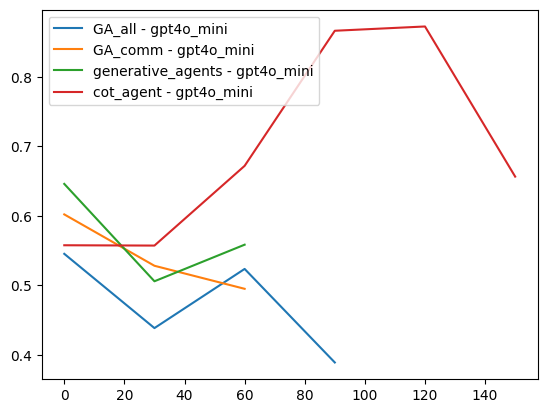

In [61]:
# Plot the performance of each arch - llm_model by bin
import matplotlib.pyplot as plt

for arch in summary:
    for llm_model in summary[arch]:
        plt.plot(list(summary[arch][llm_model].keys()), list(summary[arch][llm_model].values()), label=f'{arch} - {llm_model}')
plt.legend()

In [62]:
def avoid_taking_last_apple(trees_info, observations, action):
    OBS_WINDOW_SIZE = (11, 11)

    if re.match(r'go to', action, re.IGNORECASE):
        destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
        if destination:
            destination = tuple(map(int, destination.group(1).split(',')))
            destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                return None
            # If the destination is an apple
            elif trees_info['map'][destination[0], destination[1]] == 'A':
                trees_mask = list(map(lambda x: any(map(lambda el: el == list(destination), x['elements'])), trees_info['trees']))
                tree_id = trees_mask.index(True)

                tree = trees_info['trees_stats'][tree_id]
                apples = tree['apples']
                if apples == 1:
                    return False

    # Closest tree
    trees_distance_to_agent = list(map(lambda x: manhattan_distance(x['center'], observations['local_position']), trees_info['trees']))
    if len(trees_distance_to_agent) == 0:
        return None
    closest_tree = trees_distance_to_agent.index(min(trees_distance_to_agent))
    closest_tree_apples = trees_info['trees_stats'][closest_tree]['apples']
    if closest_tree_apples == 1:
        return True
    return None
            

In [63]:
def get_file_avoid_apple_score(file_data, type=None):
    avoided_last_apple = []
    for i in range(len(file_data['game_observations_for_act'])):
        did_avoid_last_apple = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=avoid_taking_last_apple)
        if did_avoid_last_apple is not None:
            avoided_last_apple.append(did_avoid_last_apple)
    
    times_avoided_last_apple = sum(avoided_last_apple)
    return times_avoided_last_apple / len(avoided_last_apple)
get_file_avoid_apple_score(accum_data)

0.46808510638297873

In [64]:
avoid_taking_last_apple_results = evaluate_the_complete_scenario(folder, get_file_avoid_apple_score)

total prompts: 569 invalid_prompts: 1 act_prompts 146 146 act_responses: 146
total prompts: 748 invalid_prompts: 1 act_prompts 192 192 act_responses: 192
total prompts: 582 invalid_prompts: 0 act_prompts 144 144 act_responses: 144
total prompts: 830 invalid_prompts: 0 act_prompts 214 214 act_responses: 214
total prompts: 663 invalid_prompts: 0 act_prompts 172 172 act_responses: 172
total prompts: 578 invalid_prompts: 0 act_prompts 136 136 act_responses: 136
total prompts: 641 invalid_prompts: 1 act_prompts 158 158 act_responses: 158
total prompts: 1067 invalid_prompts: 1 act_prompts 256 256 act_responses: 256
total prompts: 910 invalid_prompts: 0 act_prompts 230 230 act_responses: 230
total prompts: 738 invalid_prompts: 1 act_prompts 175 175 act_responses: 175
total prompts: 532 invalid_prompts: 0 act_prompts 128 128 act_responses: 128
total prompts: 985 invalid_prompts: 0 act_prompts 240 240 act_responses: 240
total prompts: 757 invalid_prompts: 0 act_prompts 186 186 act_responses: 18

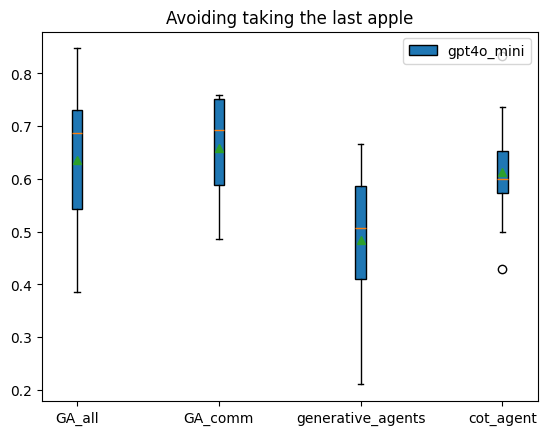

In [67]:
# Create a histogram for the average number of apples available when the agent decides to take an apple for each architecture and llm model
import matplotlib.pyplot as plt
import numpy as np

positions = np.arange(len(avoid_taking_last_apple_results)*2, step=2)
for j, arch in enumerate(avoid_taking_last_apple_results):
    for i, llm_model in enumerate(avoid_taking_last_apple_results[arch]):
        # plt.bar(positions[j*2+i], np.mean(results[arch][llm_model]), label=f'{arch} - {llm_model}')
        # Color the bars depending on the llm model
        plt.boxplot(avoid_taking_last_apple_results[arch][llm_model], positions=[j*2+i], labels=[f'{arch} - {llm_model}'], patch_artist=True, boxprops=dict(facecolor=f'C{i}'), showmeans=True)
plt.xticks(positions, avoid_taking_last_apple_results.keys())
# Add custom legend just for the colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=f'C{i}', edgecolor='black', label=llm_model) for i, llm_model in enumerate(avoid_taking_last_apple_results[arch])]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Avoiding taking the last apple')
plt.show()

In [68]:
def go_to_empty_or_grass_reasonably(trees_info, observations, action):
    OBS_WINDOW_SIZE = (11, 11)

    if re.match(r'go to', action, re.IGNORECASE):
        destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
        if destination:
            destination = tuple(map(int, destination.group(1).split(',')))
            destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                return None

            # If the destination is grass or empty
            elif trees_info['map'][destination[0], destination[1]] == 'G' or trees_info['map'][destination[0], destination[1]] == 'F':
                # If only one tree
                if len(trees_info['trees_stats']) == 1:
                    apples_in_tree = trees_info['trees_stats'][0]['apples']
                    if apples_in_tree <= 4:
                        return True
                    else:
                        return False
                else:
                    apples_in_total = sum(map(lambda x: x['apples'], trees_info['trees_stats']))
                    if apples_in_total < 5:
                        return True
                    else:
                        return False
    return None

In [69]:
def get_file_go_to_empty_or_grass_reasonably(file_data, type=None):
    go_to_empty_with_reason = []
    for i in range(len(file_data['game_observations_for_act'])):
        action_score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=go_to_empty_or_grass_reasonably)
        if action_score is not None:
            go_to_empty_with_reason.append(action_score)
    
    times_scenario_seen = sum(go_to_empty_with_reason)
    return times_scenario_seen / len(go_to_empty_with_reason), len(go_to_empty_with_reason)
get_file_go_to_empty_or_grass_reasonably(accum_data)

(0.7368421052631579, 19)

In [70]:
go_to_empty_or_grass_reasonably_results = evaluate_the_complete_scenario(folder, get_file_go_to_empty_or_grass_reasonably)
go_to_empty_or_grass_reasonably_results

total prompts: 569 invalid_prompts: 1 act_prompts 146 146 act_responses: 146
total prompts: 748 invalid_prompts: 1 act_prompts 192 192 act_responses: 192
total prompts: 582 invalid_prompts: 0 act_prompts 144 144 act_responses: 144
total prompts: 830 invalid_prompts: 0 act_prompts 214 214 act_responses: 214
total prompts: 663 invalid_prompts: 0 act_prompts 172 172 act_responses: 172
total prompts: 578 invalid_prompts: 0 act_prompts 136 136 act_responses: 136
total prompts: 641 invalid_prompts: 1 act_prompts 158 158 act_responses: 158
total prompts: 1067 invalid_prompts: 1 act_prompts 256 256 act_responses: 256
total prompts: 910 invalid_prompts: 0 act_prompts 230 230 act_responses: 230
total prompts: 738 invalid_prompts: 1 act_prompts 175 175 act_responses: 175
total prompts: 532 invalid_prompts: 0 act_prompts 128 128 act_responses: 128
total prompts: 985 invalid_prompts: 0 act_prompts 240 240 act_responses: 240
total prompts: 757 invalid_prompts: 0 act_prompts 186 186 act_responses: 18

{'GA_all': {'gpt4o_mini': [(0.7368421052631579, 19),
   (0.6666666666666666, 27),
   (0.42105263157894735, 19),
   (0.7, 30),
   (0.7241379310344828, 29),
   (0.7142857142857143, 14),
   (0.8484848484848485, 33),
   (0.6842105263157895, 38),
   (0.6829268292682927, 41),
   (0.30303030303030304, 33)]},
 'GA_comm': {'gpt4o_mini': [(0.5625, 16),
   (0.5686274509803921, 51),
   (0.7272727272727273, 22),
   (0.9166666666666666, 24),
   (0.6111111111111112, 18),
   (0.59375, 32)]},
 'generative_agents': {'gpt4o_mini': [(0.8571428571428571, 28),
   (0.9310344827586207, 29),
   (0.875, 32),
   (0.5384615384615384, 13),
   (0.9523809523809523, 42),
   (0.75, 12),
   (0.8620689655172413, 29),
   (0.8095238095238095, 21),
   (0.8888888888888888, 36),
   (0.7777777777777778, 18)]},
 'cot_agent': {'gpt4o_mini': [(0.4583333333333333, 24),
   (0.3181818181818182, 22),
   (0.5714285714285714, 21),
   (0.5882352941176471, 17),
   (0.5384615384615384, 26),
   (0.42105263157894735, 19),
   (0.46153846153

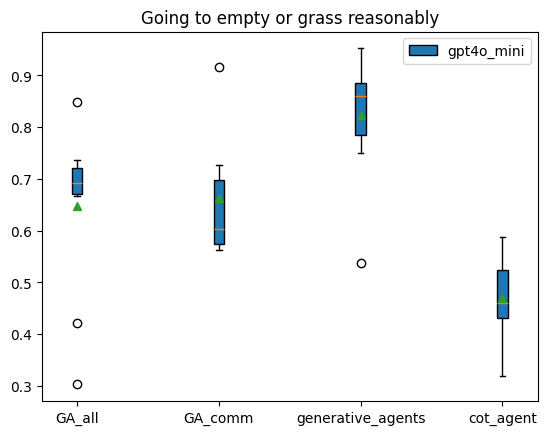

In [71]:
positions = np.arange(len(avoid_taking_last_apple_results)*2, step=2)
for j, arch in enumerate(go_to_empty_or_grass_reasonably_results):
    for i, llm_model in enumerate(go_to_empty_or_grass_reasonably_results[arch]):
        # plt.bar(positions[j*2+i], np.mean(go_to_empty_or_grass_reasonably_results[arch][llm_model]), label=f'{arch} - {llm_model}')
        # Color the bars depending on the llm model
        model_go_to_empty_or_grass_reasonably_results = go_to_empty_or_grass_reasonably_results[arch][llm_model]
        model_go_to_empty_or_grass_reasonably_results = list(map(lambda x: x[0], model_go_to_empty_or_grass_reasonably_results))
        plt.boxplot(model_go_to_empty_or_grass_reasonably_results, positions=[j*2+i], labels=[f'{arch} - {llm_model}'], patch_artist=True, boxprops=dict(facecolor=f'C{i}'), showmeans=True)
plt.xticks(positions, go_to_empty_or_grass_reasonably_results.keys())
# Add custom legend just for the colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=f'C{i}', edgecolor='black', label=llm_model) for i, llm_model in enumerate(go_to_empty_or_grass_reasonably_results[arch])]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Going to empty or grass reasonably')
plt.show()

In [72]:
def take_apple_from_abundant_tree(trees_info, observations, action):
    OBS_WINDOW_SIZE = (11, 11)

    if re.match(r'go to', action, re.IGNORECASE):
        destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
        if destination:
            destination = tuple(map(int, destination.group(1).split(',')))
            destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                return None

            elif trees_info['map'][destination[0], destination[1]] == 'A':
                trees_mask = list(map(lambda x: any(map(lambda el: el == list(destination), x['elements'])), trees_info['trees']))
                tree_id = trees_mask.index(True)

                tree = trees_info['trees_stats'][tree_id]
                apples = tree['apples']
                if apples >= 4:
                    return True
                elif apples < 4:
                    return False
    return None

In [73]:
def get_file_take_apple_from_abundant_tree(file_data, type=None):
    go_to_empty_with_reason = []
    for i in range(len(file_data['game_observations_for_act'])):
        action_score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=take_apple_from_abundant_tree)
        if action_score is not None:
            go_to_empty_with_reason.append(action_score)
    
    times_scenario_seen = sum(go_to_empty_with_reason)
    return times_scenario_seen / len(go_to_empty_with_reason), len(go_to_empty_with_reason)
get_file_take_apple_from_abundant_tree(accum_data)

(0.46875, 64)

In [74]:
results = evaluate_the_complete_scenario(folder, get_file_take_apple_from_abundant_tree)
results

total prompts: 569 invalid_prompts: 1 act_prompts 146 146 act_responses: 146
total prompts: 748 invalid_prompts: 1 act_prompts 192 192 act_responses: 192
total prompts: 582 invalid_prompts: 0 act_prompts 144 144 act_responses: 144
total prompts: 830 invalid_prompts: 0 act_prompts 214 214 act_responses: 214
total prompts: 663 invalid_prompts: 0 act_prompts 172 172 act_responses: 172
total prompts: 578 invalid_prompts: 0 act_prompts 136 136 act_responses: 136
total prompts: 641 invalid_prompts: 1 act_prompts 158 158 act_responses: 158
total prompts: 1067 invalid_prompts: 1 act_prompts 256 256 act_responses: 256
total prompts: 910 invalid_prompts: 0 act_prompts 230 230 act_responses: 230
total prompts: 738 invalid_prompts: 1 act_prompts 175 175 act_responses: 175
total prompts: 532 invalid_prompts: 0 act_prompts 128 128 act_responses: 128
total prompts: 985 invalid_prompts: 0 act_prompts 240 240 act_responses: 240
total prompts: 757 invalid_prompts: 0 act_prompts 186 186 act_responses: 18

{'GA_all': {'gpt4o_mini': [(0.46875, 64),
   (0.4393939393939394, 66),
   (0.47540983606557374, 61),
   (0.5256410256410257, 78),
   (0.5571428571428572, 70),
   (0.5373134328358209, 67),
   (0.4875, 80),
   (0.5348837209302325, 86),
   (0.6575342465753424, 73),
   (0.6428571428571429, 84)]},
 'GA_comm': {'gpt4o_mini': [(0.5409836065573771, 61),
   (0.6142857142857143, 70),
   (0.4430379746835443, 79),
   (0.6607142857142857, 56),
   (0.5189873417721519, 79),
   (0.64, 50)]},
 'generative_agents': {'gpt4o_mini': [(0.5172413793103449, 58),
   (0.6027397260273972, 73),
   (0.40350877192982454, 57),
   (0.6363636363636364, 55),
   (0.5151515151515151, 66),
   (0.43103448275862066, 58),
   (0.5333333333333333, 45),
   (0.5675675675675675, 74),
   (0.42857142857142855, 63),
   (0.6486486486486487, 74)]},
 'cot_agent': {'gpt4o_mini': [(0.3, 20),
   (0.5652173913043478, 23),
   (0.5588235294117647, 34),
   (0.55, 20),
   (0.5277777777777778, 36),
   (0.4375, 32),
   (0.4, 25),
   (0.428571428

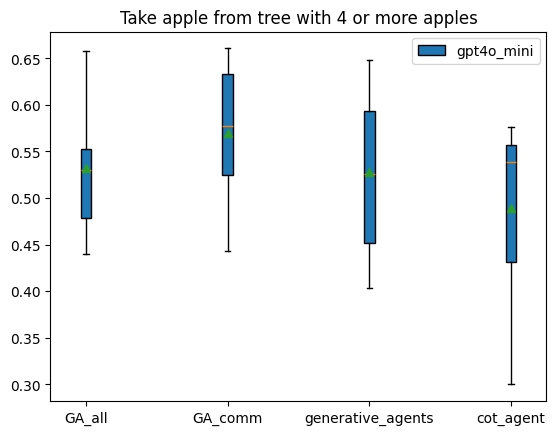

In [75]:
positions = np.arange(len(avoid_taking_last_apple_results)*2, step=2)
for j, arch in enumerate(results):
    for i, llm_model in enumerate(results[arch]):
        # Color the bars depending on the llm model
        model_results = results[arch][llm_model]
        model_results = list(map(lambda x: x[0], model_results))
        plt.boxplot(model_results, positions=[j*2+i], labels=[f'{arch} - {llm_model}'], patch_artist=True, boxprops=dict(facecolor=f'C{i}'), showmeans=True)
plt.xticks(positions, results.keys())
# Add custom legend just for the colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=f'C{i}', edgecolor='black', label=llm_model) for i, llm_model in enumerate(results[arch])]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Take apple from tree with 4 or more apples')
plt.show()

In [76]:
def take_apple_from_tree_with_more_apples(trees_info, observations, action):
    OBS_WINDOW_SIZE = (11, 11)

    if re.match(r'go to', action, re.IGNORECASE):
        destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
        if destination:
            destination = tuple(map(int, destination.group(1).split(',')))
            destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                return None
            
            if trees_info['map'][destination[0], destination[1]] != 'A':
                return None
            
            # If there is another agent
            if len(observations['agents_in_observation'].values()) > 0:
                trees_mask = list(map(lambda x: any(map(lambda el: el == list(destination), x['elements'])), trees_info['trees']))
                tree_id = trees_mask.index(True)

                tree_with_more_apples = max(trees_info['trees_stats'], key=lambda x: x['apples'])
                tree_with_more_apples_id = trees_info['trees_stats'].index(tree_with_more_apples)

                if tree_with_more_apples_id == tree_id:
                    return True
                else:
                    return False
                    
    return None

In [77]:
def get_file_take_apple_from_tree_with_more_apples(file_data, type=None):
    go_to_empty_with_reason = []
    for i in range(len(file_data['game_observations_for_act'])):
        action_score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=take_apple_from_tree_with_more_apples)
        if action_score is not None:
            go_to_empty_with_reason.append(action_score)
    
    times_scenario_seen = sum(go_to_empty_with_reason)
    if not len(go_to_empty_with_reason):
        return None, 0
    return times_scenario_seen / len(go_to_empty_with_reason), len(go_to_empty_with_reason)
get_file_take_apple_from_tree_with_more_apples(accum_data)

(0.72, 50)

In [78]:
results = evaluate_the_complete_scenario(folder, get_file_take_apple_from_tree_with_more_apples)
results

total prompts: 569 invalid_prompts: 1 act_prompts 146 146 act_responses: 146
total prompts: 748 invalid_prompts: 1 act_prompts 192 192 act_responses: 192
total prompts: 582 invalid_prompts: 0 act_prompts 144 144 act_responses: 144
total prompts: 830 invalid_prompts: 0 act_prompts 214 214 act_responses: 214
total prompts: 663 invalid_prompts: 0 act_prompts 172 172 act_responses: 172
total prompts: 578 invalid_prompts: 0 act_prompts 136 136 act_responses: 136
total prompts: 641 invalid_prompts: 1 act_prompts 158 158 act_responses: 158
total prompts: 1067 invalid_prompts: 1 act_prompts 256 256 act_responses: 256
total prompts: 910 invalid_prompts: 0 act_prompts 230 230 act_responses: 230
total prompts: 738 invalid_prompts: 1 act_prompts 175 175 act_responses: 175
total prompts: 532 invalid_prompts: 0 act_prompts 128 128 act_responses: 128
total prompts: 985 invalid_prompts: 0 act_prompts 240 240 act_responses: 240
total prompts: 757 invalid_prompts: 0 act_prompts 186 186 act_responses: 18

{'GA_all': {'gpt4o_mini': [(0.72, 50),
   (0.625, 56),
   (0.6792452830188679, 53),
   (0.6111111111111112, 54),
   (0.6875, 48),
   (0.7272727272727273, 55),
   (0.6, 60),
   (0.6764705882352942, 68),
   (0.7758620689655172, 58),
   (0.7846153846153846, 65)]},
 'GA_comm': {'gpt4o_mini': [(0.7291666666666666, 48),
   (0.7818181818181819, 55),
   (0.5789473684210527, 76),
   (0.625, 40),
   (0.6307692307692307, 65),
   (0.6944444444444444, 36)]},
 'generative_agents': {'gpt4o_mini': [(0.5952380952380952, 42),
   (0.6595744680851063, 47),
   (0.7435897435897436, 39),
   (0.6666666666666666, 36),
   (0.6808510638297872, 47),
   (0.6595744680851063, 47),
   (0.59375, 32),
   (0.6875, 48),
   (0.6938775510204082, 49),
   (0.7666666666666667, 60)]},
 'cot_agent': {'gpt4o_mini': [(0.7857142857142857, 14),
   (0.8421052631578947, 19),
   (0.75, 24),
   (0.7777777777777778, 18),
   (0.8928571428571429, 28),
   (0.8095238095238095, 21),
   (0.5, 18),
   (0.75, 16),
   (0.7727272727272727, 22),
 

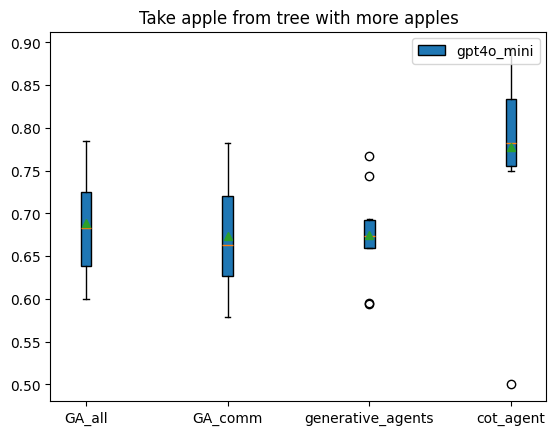

In [79]:
positions = np.arange(len(avoid_taking_last_apple_results)*2, step=2)
for j, arch in enumerate(results):
    for i, llm_model in enumerate(results[arch]):
        # Color the bars depending on the llm model
        model_results = results[arch][llm_model]
        model_results = list(map(lambda x: x[0], model_results))
        plt.boxplot(model_results, positions=[j*2+i], labels=[f'{arch} - {llm_model}'], patch_artist=True, boxprops=dict(facecolor=f'C{i}'), showmeans=True)
plt.xticks(positions, results.keys())
# Add custom legend just for the colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=f'C{i}', edgecolor='black', label=llm_model) for i, llm_model in enumerate(results[arch])]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Take apple from tree with more apples')
plt.show()

In [80]:
def take_apple_when_few_tree(trees_info, observations, action):
    OBS_WINDOW_SIZE = (11, 11)

    all_observed_apples = sum(map(lambda x: x['apples'], trees_info['trees_stats']))
    if all_observed_apples > 4:
        return None

    if re.match(r'go to', action, re.IGNORECASE):
        destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
        if destination:
            destination = tuple(map(int, destination.group(1).split(',')))
            destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                return False
            elif trees_info['map'][destination[0], destination[1]] == 'A':
                return True
    return False

In [81]:
def get_file_take_apple_when_few_tree(file_data, type=None):
    go_to_empty_with_reason = []
    for i in range(len(file_data['game_observations_for_act'])):
        action_score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=take_apple_when_few_tree)
        if action_score is not None:
            go_to_empty_with_reason.append(action_score)
    
    times_scenario_seen = sum(go_to_empty_with_reason)
    if not len(go_to_empty_with_reason):
        return None, 0
    return times_scenario_seen / len(go_to_empty_with_reason), len(go_to_empty_with_reason)
get_file_take_apple_when_few_tree(accum_data)

(0.3163265306122449, 98)

In [82]:
results = evaluate_the_complete_scenario(folder, get_file_take_apple_when_few_tree)

total prompts: 569 invalid_prompts: 1 act_prompts 146 146 act_responses: 146
total prompts: 748 invalid_prompts: 1 act_prompts 192 192 act_responses: 192
total prompts: 582 invalid_prompts: 0 act_prompts 144 144 act_responses: 144
total prompts: 830 invalid_prompts: 0 act_prompts 214 214 act_responses: 214
total prompts: 663 invalid_prompts: 0 act_prompts 172 172 act_responses: 172
total prompts: 578 invalid_prompts: 0 act_prompts 136 136 act_responses: 136
total prompts: 641 invalid_prompts: 1 act_prompts 158 158 act_responses: 158
total prompts: 1067 invalid_prompts: 1 act_prompts 256 256 act_responses: 256
total prompts: 910 invalid_prompts: 0 act_prompts 230 230 act_responses: 230
total prompts: 738 invalid_prompts: 1 act_prompts 175 175 act_responses: 175
total prompts: 532 invalid_prompts: 0 act_prompts 128 128 act_responses: 128
total prompts: 985 invalid_prompts: 0 act_prompts 240 240 act_responses: 240
total prompts: 757 invalid_prompts: 0 act_prompts 186 186 act_responses: 18

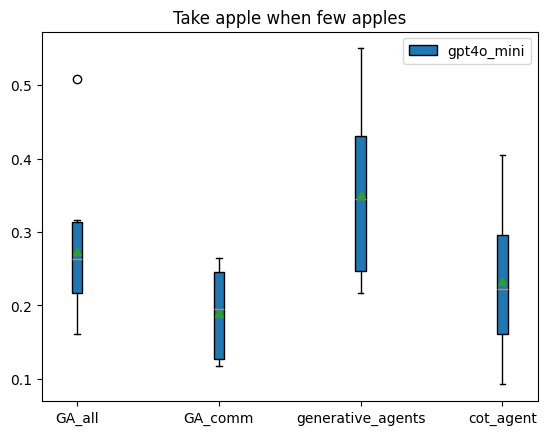

In [83]:
positions = np.arange(len(avoid_taking_last_apple_results)*2, step=2)
for j, arch in enumerate(results):
    for i, llm_model in enumerate(results[arch]):
        # Color the bars depending on the llm model
        model_results = results[arch][llm_model]
        model_results = list(map(lambda x: x[0], model_results))
        plt.boxplot(model_results, positions=[j*2+i], labels=[f'{arch} - {llm_model}'], patch_artist=True, boxprops=dict(facecolor=f'C{i}'), showmeans=True)
plt.xticks(positions, results.keys())
# Add custom legend just for the colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=f'C{i}', edgecolor='black', label=llm_model) for i, llm_model in enumerate(results[arch])]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Take apple when few apples')
plt.show()

In [84]:
def explore_when_enough_apples(trees_info, observations, action):
    all_observed_apples = sum(map(lambda x: x['apples'], trees_info['trees_stats']))
    if all_observed_apples <= 4:
        return None

    if re.match(r'explore', action, re.IGNORECASE):
        return True
    return False

In [85]:
def get_file_explore_when_enough_apples(file_data, type=None):
    go_to_empty_with_reason = []
    for i in range(len(file_data['game_observations_for_act'])):
        action_score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=explore_when_enough_apples)
        if action_score is not None:
            go_to_empty_with_reason.append(action_score)
    
    times_scenario_seen = sum(go_to_empty_with_reason)
    if not len(go_to_empty_with_reason):
        return None, 0
    return times_scenario_seen / len(go_to_empty_with_reason), len(go_to_empty_with_reason)
get_file_explore_when_enough_apples(accum_data)

(0.0, 47)

In [86]:
explore_when_enough_apples_results = evaluate_the_complete_scenario(folder, get_file_explore_when_enough_apples)

total prompts: 569 invalid_prompts: 1 act_prompts 146 146 act_responses: 146
total prompts: 748 invalid_prompts: 1 act_prompts 192 192 act_responses: 192
total prompts: 582 invalid_prompts: 0 act_prompts 144 144 act_responses: 144
total prompts: 830 invalid_prompts: 0 act_prompts 214 214 act_responses: 214
total prompts: 663 invalid_prompts: 0 act_prompts 172 172 act_responses: 172
total prompts: 578 invalid_prompts: 0 act_prompts 136 136 act_responses: 136
total prompts: 641 invalid_prompts: 1 act_prompts 158 158 act_responses: 158
total prompts: 1067 invalid_prompts: 1 act_prompts 256 256 act_responses: 256
total prompts: 910 invalid_prompts: 0 act_prompts 230 230 act_responses: 230
total prompts: 738 invalid_prompts: 1 act_prompts 175 175 act_responses: 175
total prompts: 532 invalid_prompts: 0 act_prompts 128 128 act_responses: 128
total prompts: 985 invalid_prompts: 0 act_prompts 240 240 act_responses: 240
total prompts: 757 invalid_prompts: 0 act_prompts 186 186 act_responses: 18

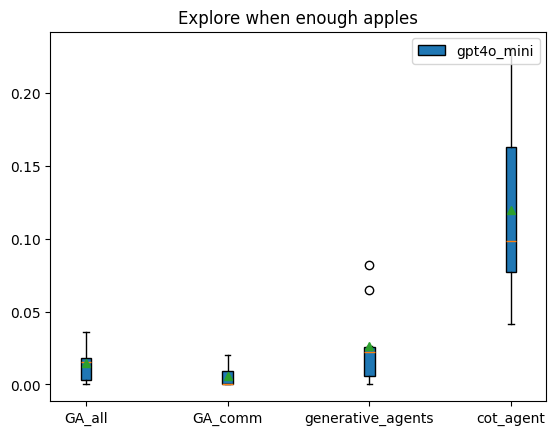

In [87]:
positions = np.arange(len(avoid_taking_last_apple_results)*2, step=2)
for j, arch in enumerate(explore_when_enough_apples_results):
    for i, llm_model in enumerate(explore_when_enough_apples_results[arch]):
        # Color the bars depending on the llm model
        model_results = explore_when_enough_apples_results[arch][llm_model]
        model_results = list(map(lambda x: x[0], model_results))
        plt.boxplot(model_results, positions=[j*2+i], labels=[f'{arch} - {llm_model}'], patch_artist=True, boxprops=dict(facecolor=f'C{i}'), showmeans=True)
plt.xticks(positions, explore_when_enough_apples_results.keys())
# Add custom legend just for the colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=f'C{i}', edgecolor='black', label=llm_model) for i, llm_model in enumerate(explore_when_enough_apples_results[arch])]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Explore when enough apples')
plt.show()

### Paper indicators image

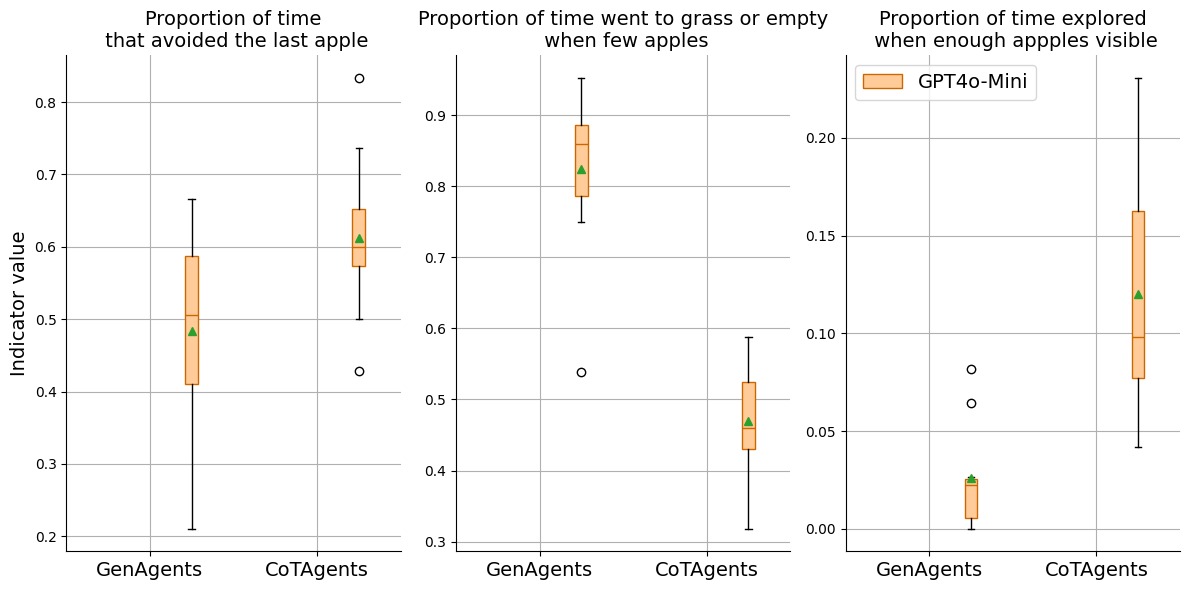

In [42]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Colors for each specific model (orange for GPT4o-mini and blue for GPT4o)
subcat_colors = [
    {"facecolor": "#66b3ff", "color": "#003366"},  # GPT4o (CoTAgents y GenAgents)
    {"facecolor": "#ffcc99", "color": "#cc6600"},  # GPT4o-mini (CoTAgents y GenAgents)
]

# Labels for the legend (GPT4o-mini and GPT4o)
legend_labels = [
    "GPT4o-mini",
    "GPT4o"
]

avoid_taking_last_apple_data ={
    'GenerativeAgents': {
        'gpt4o':  [],
        'gpt4o_mini': avoid_taking_last_apple_results['generative_agents']['gpt4o_mini'],
    },
    'CoTAgent': {
        'gpt4o':  [],
        'gpt4o_mini': avoid_taking_last_apple_results['cot_agent']['gpt4o_mini'],
    },
}

go_to_empty_or_grass_reasonably_data ={
    'GenerativeAgents': {
        'gpt4o':  [],
        'gpt4o_mini': [el[0] for el in go_to_empty_or_grass_reasonably_results['generative_agents']['gpt4o_mini']],
    },
    'CoTAgent': {
        'gpt4o':  [],
        'gpt4o_mini': [el[0] for el in go_to_empty_or_grass_reasonably_results['cot_agent']['gpt4o_mini']],
    },
}

explore_when_enough_apples_data ={
    'GenerativeAgents': {
        'gpt4o':  [],
        'gpt4o_mini': [el[0] for el in explore_when_enough_apples_results['generative_agents']['gpt4o_mini']],
    },
    'CoTAgent': {
        'gpt4o':  [],
        'gpt4o_mini': [el[0] for el in explore_when_enough_apples_results['cot_agent']['gpt4o_mini']],
    },
}

# Create subplots for each scenario with improved graphics
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Define positions
positions = [1, 2, 3, 4]

# Function to plot boxplots with individual legends and titles
def plot_boxplot(ax, data, title, colors, use_legend = True):
    all_data = []
    for agent in data:
        for model in data[agent]:
            all_data.append(data[agent][model])
    
    # Create boxplots for each model with custom colors
    for idx, model_data in enumerate(all_data):
        color_idx = idx % 2  # Alternate colors between GPT4o_mini and GPT4o
        boxprops = colors[color_idx]
        ax.boxplot(model_data, positions=[positions[idx]], patch_artist=True,
                   boxprops=dict(facecolor=boxprops["facecolor"], color=boxprops["color"]),
                   medianprops=dict(color=boxprops["color"]), showmeans=True)
    
    ax.set_title(title, fontsize=14)
    ax.set_xticks([1.5, 3.5])  # Position the ticks between the grouped models
    ax.set_xticklabels(['GenAgents', 'CoTAgents'], fontsize=14)
    ax.grid(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Add a legend
    legend_elements = [
        # Patch(facecolor=colors[0]['facecolor'], edgecolor=colors[0]['color'], label="GPT4o"),
        Patch(facecolor=colors[1]['facecolor'], edgecolor=colors[1]['color'], label="GPT4o-Mini"),
    ]
    if use_legend:
        ax.legend(handles=legend_elements, loc='upper left', fontsize=14)

# Plot each indicator
plot_boxplot(axs[0], avoid_taking_last_apple_data, "Proportion of time\n that avoided the last apple", subcat_colors, use_legend=False)
plot_boxplot(axs[1], go_to_empty_or_grass_reasonably_data, "Proportion of time went to grass or empty\n when few apples", subcat_colors, use_legend=False)
plot_boxplot(axs[2], explore_when_enough_apples_data, "Proportion of time explored\n when enough appples visible", subcat_colors)


# Add a common y-axis label
#fig.text(0.04, 0.5, 'Performance', va='center', rotation='vertical', fontsize=12)

# Add overall labels and title
#fig.suptitle("Coins Scenario 1 - Agents Performance Indicators", fontsize=18)
axs[0].set_ylabel("Indicator value", fontsize=14)

# Adjust layout and save the figure
plt.tight_layout()
# plt.savefig("boxplot_comparison.png", dpi=800)
plt.show()